# Case Study 1

## Imports

In [66]:
# imports
import pandas as pd
from math import floor
from random import sample
import seaborn as sns

### Parameters

In [14]:
macs_to_keep = ['00:0f:a3:39:e1:c0',    
            '00:0f:a3:39:dd:cd', 
            '00:14:bf:b1:97:8a',
            '00:14:bf:3b:c7:c6',    
            '00:14:bf:b1:97:90',  
            '00:14:bf:b1:97:8d',
            '00:14:bf:b1:97:81',
            '02:00:42:55:31:00']

### Code/Functions

In [94]:
def cross_validate(sample_data, test_data, ks, m):
    #m = 3 # determines number of angles swept in each call to get training data
    #ks = range(2, 10) #search space for kNN algo 
    online = test_data.copy().reset_index()
    all_predictions = []
    for k in ks:
        print(k)
        predictions = []
        for index, sample_row in online.iterrows():
            sample = get_train_data_by_angle(data=sample_data
                                             , ref_angle=sample_row['dummy_angle']
                                             , angles=m)
            sample = calc_distance(sample, sample_row)
            sample = sample.reset_index()
            #k sets nearest neighbors used for predictions
            p = predict(sample, k=k, weight=True)
            p.update({
                'k': k,
                'target_x': float(sample_row['xy-loc'].split('-')[0]),
                'target_y': float(sample_row['xy-loc'].split('-')[1])
            })
            predictions.append(
                p
            )
        all_predictions += predictions
        
            
    return pd.DataFrame(all_predictions)

def score(predictions):
    predictions = predictions.copy()
    predictions['error'] = [((row['target_x'] - row['pred_x'])**2+((row['target_y'] - row['pred_y'])**2))**.5 for x, row in predictions.iterrows()]
    predictions['error_weighted'] = [((row['target_x'] - row['pred_x_weighted'])**2+((row['target_y'] - row['pred_y_weighted'])**2))**.5 for x, row in predictions.iterrows()]
    return predictions

def round_angle(angle):
    buckets = [angle for angle in angle_buckets()]
    angle = angle if angle < 360 else angle-360
    angles = [abs(a - angle) for a in buckets]
    sorted_angles = angles.copy()
    sorted_angles.sort()
    min_val = sorted_angles[0]
    min_index = angles.index(min_val)
    return buckets[min_index]
    

def angle_buckets(start = 0, end = 360, step = 45):
     for i in range(0, int(round(end/step, 0)) + 1):
            val = start + i*step
            yield val

angles = [a for a in angle_buckets()]

def get_train_data_by_angle(data, ref_angle=225, angles=3):
    ref_angle = round_angle(ref_angle)
    #assert angles <= 7
    buckets = [angle for angle in angle_buckets()]
    if angles:
        start_index = buckets.index(ref_angle)- int(floor(angles/2))
        keep_angles = []
        for x in range(start_index, start_index + angles):
            keep_angles.append(buckets[x])
        #print(keep_angles)
        data = data[data['mapped_orientation'].isin(keep_angles)].copy()
    grouped_df = data.groupby(['mac', 'xy-loc'])['signal'].agg(['mean']).reset_index()
    grouped_df = pd.pivot_table(grouped_df, values='mean', columns='mac', index=['xy-loc'])
    assert grouped_df.shape[0] == 166
    return grouped_df

def calc_distance(sample_data, test_row):
    differences = []
    for index, row in sample_data.iterrows():
        diff = sum([(row[col]-test_row[col])**2 for col in macs_to_keep])**0.5
        #test_row.loc[index, 'distance'] = diff
        differences.append(diff)
    sample_data['distance'] = differences
    return sample_data.sort_values(['distance'])


def predict(sample_data, k=3, weight=False):
    sample_data = sample_data.head(k).copy()
    sample_data['x'] = sample_data['xy-loc'].apply(lambda x: x.split('-')[0])
    sample_data['y'] = sample_data['xy-loc'].apply(lambda y: y.split('-')[1])
    sample_data['x'] = pd.to_numeric(sample_data['x'])
    sample_data['y'] = pd.to_numeric(sample_data['y'])
    sample_data['inverse_distance'] = 1/sample_data['distance']
    total_inv_dist = sample_data['inverse_distance'].sum()
    sample_data['distance_weight'] = sample_data['inverse_distance']/total_inv_dist
    assert sample_data.shape[0] == k
    return {
        'pred_x':sample_data['x'].mean(),
        'pred_y': sample_data['y'].mean(),
        'pred_x_weighted': (sample_data['x'] * sample_data['distance_weight']).sum(),
        'pred_y_weighted':  (sample_data['y'] * sample_data['distance_weight']).sum(),
        'inv_dist':total_inv_dist
    }


f_offline = '../Data/offline.final.trace.txt'
f_online = '../Data/online.final.trace.txt'

def get_data(file_name, add_dummy=False, macs=macs_to_keep, agg=False):
    column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']
    lines = None
    with open(file_name, 'r') as file:
        lines = file.readlines()
        file.close()
    instances = [] # will hold final data for dataframe

    for line in lines:

        # strip "\n" from line
        line = line.rstrip('\n')

        # skip if comment
        if line[0] == '#':
            continue

        base = [] # [t, id, x, y, z, degree]
        rows = [] # base + [mac, signal, channel, type]

        for keyvalue in line.split(';'):
            key, value = keyvalue.split('=')

            if key in ['t', 'id', 'degree']:
                base.append(value)
            elif key == 'pos':
                # pos (x, y, z)
                base += value.split(',')
            else:
                # mac addresses and metrics (signal, channel, type)
                row = base.copy()
                row.append(key)
                row += value.split(',')
                rows.append(row)

        instances += rows

    df_online = pd.DataFrame(instances, columns = column_names)
    df_online.orientation = pd.to_numeric(df_online['orientation'])
    df_online['mapped_orientation'] = df_online['orientation'].apply(lambda x: round_angle(x))

    df_online['xy-loc'] = df_online['posX'] + '-' + df_online['posY']


    df_online['signal'] = pd.to_numeric(df_online['signal'])
    df_online = df_online[df_online.mac.isin(macs)].copy()

    if agg:
        df_online = df_online.groupby(['mac', 'xy-loc'])['signal'].agg(['mean']).reset_index()
        df_online = pd.pivot_table(df_online, values='mean', columns='mac', index=['xy-loc'])
    
    if add_dummy:
    ## add dummy angle
        df_online['dummy_angle'] = df_online.apply(lambda x: sample(angles, 1)[0], axis=1)
    return df_online
    #df_online.head()

## Create DataFrame

**df** : training set. Not aggregated by angle. **Will be aggregated by XY-loc and mac across orientation angles on demand as needed**

**df_online** : testing set. Aggregated at outset, not touched until after cross validation.

In [30]:
df = get_data(f_offline)
df_online = get_data(f_online, add_dummy=True, agg=True)

In [31]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018838 entries, 0 to 1181626
Data columns (total 12 columns):
time                  1018838 non-null object
scanMac               1018838 non-null object
posX                  1018838 non-null object
posY                  1018838 non-null object
posZ                  1018838 non-null object
orientation           1018838 non-null float64
mac                   1018838 non-null object
signal                1018838 non-null int64
channel               1018838 non-null object
type                  1018838 non-null object
mapped_orientation    1018838 non-null int64
xy-loc                1018838 non-null object
dtypes: float64(1), int64(2), object(9)
memory usage: 101.1+ MB
None


time            scanMac posX posY posZ  orientation  \
0  1139643118358  00:02:2D:21:0F:33  0.0  0.0  0.0          0.0   
1  1139643118358  00:02:2D:21:0F:33  0.0  0.0  0.0          0.0   
2  1139643118358  00:02:2D:21:0F:33  0.0  0.0  0.0          0.0   
3  1139643118358  00:02:2D:21:0F:33  0.0  0.0  0.0          0.0   
4  1139643118358  00:02:2D:21:0F:33  0.0  0.0  0.0          0.0   

                 mac  signal     channel type  mapped_orientation   xy-loc  
0  00:14:bf:b1:97:8a     -38  2437000000    3                   0  0.0-0.0  
1  00:14:bf:b1:97:90     -56  2427000000    3                   0  0.0-0.0  
2  00:0f:a3:39:e1:c0     -53  2462000000    3                   0  0.0-0.0  
3  00:14:bf:b1:97:8d     -65  2442000000    3                   0  0.0-0.0  
4  00:14:bf:b1:97:81     -65  2422000000    3                   0  0.0-0.0

In [32]:
print(df_online.info())
df_online.head()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0.0-0.05 to 9.86-3.88
Data columns (total 9 columns):
00:0f:a3:39:dd:cd    60 non-null float64
00:0f:a3:39:e1:c0    60 non-null float64
00:14:bf:3b:c7:c6    60 non-null float64
00:14:bf:b1:97:81    60 non-null float64
00:14:bf:b1:97:8a    60 non-null float64
00:14:bf:b1:97:8d    60 non-null float64
00:14:bf:b1:97:90    60 non-null float64
02:00:42:55:31:00    60 non-null float64
dummy_angle          60 non-null int64
dtypes: float64(8), int64(1)
memory usage: 4.7+ KB
None


mac         00:0f:a3:39:dd:cd  00:0f:a3:39:e1:c0  00:14:bf:3b:c7:c6  \
xy-loc                                                                
0.0-0.05           -63.207207         -52.227273         -62.948980   
0.15-9.42          -66.117117         -55.275229         -73.961905   
0.31-11.09         -67.054054         -51.709091         -70.082474   
0.47-8.2           -74.153153         -49.500000         -64.258065   
0.78-10.94         -71.403670         -53.263636         -66.960000   

mac         00:14:bf:b1:97:81  00:14:bf:b1:97:8a  00:14:bf:b1:97:8d  \
xy-loc                                                                
0.0-0.05           -61.813953         -40.068966         -63.043011   
0.15-9.42          -72.701031         -47.813084         -69.454545   
0.31-11.09         -70.098901         -54.088235         -69.131579   
0.47-8.2           -72.597701         -45.652893         -60.797468   
0.78-10.94         -66.809524         -48.413793         -65.000000   

mac         00:14:bf:b1:97:90  02:00:42:55:31:00  dummy_angle  
xy-loc                                                         
0.0-0.05           -55.233333         -86.369863           90  
0.15-9.42          -46.880000         -88.712766            0  
0.31-11.09         -53.886598         -86.985507          360  
0.47-8.2           -49.580000         -85.341463          270  
0.78-10.94         -54.846939         -88.032258          135

***Online Test Set Should Flatten out to 60 rows***

In [36]:
assert df_online.shape[0] == 60

### Distance Measurements and Error

Distance between two points in space will be defined as the **euclidean** distance between the point we wish to classify and the collection of points in our sample **signal space** (a n-dimensional space consisting of each mac address' signal reading).

$$d_{signal space}=\sqrt{\sum_{i=1}^{i=n}{({S_{i}-{T}_{i}})^2}}$$

Error will similarly be evaluated, but in the more traditional euclidean distance represented in 2-d space (i.e the **pythagorean theorem**). Using this as a metric for scoring (lower is better) will allow us to distinguish the best algorithm parameters. 

$$Error_{prediction}=\sqrt{({X_{target}-{X}_{predicted}})^2 + ({Y_{target}-{Y}_{predicted}})^2}$$

Additionally, we will use an inverse distance weighting to weight our XY predictions in our nearest neighbor algorithm to see if we can smooth out the effect of increasing values of k.

$$Weight_{i}=\frac{1/d_{i}}{\sum_{j=1}^{j=k}{1/d_{j}}}$$

### Train/test split

**Optimal k** - we'll search for the optimal value of k (the number of neighbors to be included in making our prediction) by performing a **5 fold cross validation** on a range of **ks from 2-20**. Each fold will consist of an **80/20 train/test split** for the entire offline dataset. 80% will be used to form our nearest neighbor graph which will then be used to estimate the X-Y location of the remaining 20% of points. 

The parameter m will be set to **three** for this particular selection of k. Setting m to 3 will run this cross val using a sample from 3 angle orientations that bracket the dummy angle provided in the set (**which is randomly assigned**). If an angle of 45 is passed into the filter, the training set will consist of angles in [0, 45, 90]. 

In [103]:
cross_val_results = []
#not checking angle balance here is a problem -  note in summary
for fold in range(1, 6): #5 folds
    all_indices = set(df.index)
    keep = int(round(len(all_indices)*0.8, 0))
    train_labels = set(sample(all_indices, keep))
    test_labels = all_indices.difference(train_labels)
    train_data = df.loc[train_labels]
    test_data = df.loc[test_labels]
    test_data = test_data.groupby(['mac', 'xy-loc'])['signal'].agg(['mean']).reset_index()
    test_data = pd.pivot_table(test_data, values='mean', columns='mac', index=['xy-loc'])
    test_data['dummy_angle'] = test_data.apply(lambda x: sample(angles, 1)[0], axis=1)
    cv = cross_validate(train_data, test_data, ks=range(2, 20), m=3)
    cv['fold'] = fold
    cross_val_results.append(cv)
    print(f'Fold: {fold} completed')
    
cross_val_results = pd.concat(cross_val_results)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Fold: 1 completed
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Fold: 2 completed
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Fold: 3 completed
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Fold: 4 completed
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Fold: 5 completed


[Text(0, 0.5, 'error'), Text(0.5, 1.0, 'Error vs k')]

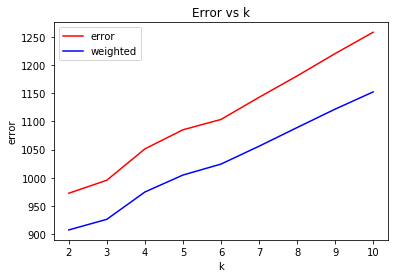

In [144]:
results = []
for k, predictions in cross_val_results.groupby(['k']):
    scored = score(predictions)
    error = scored.error.sum()
    error_weighted = scored.error_weighted.sum()
    results.append({
        'k':k,
        'error':error,
        'error_weighted':error_weighted
    })

results = pd.DataFrame(results)
results = results[results.k <= 10]
p = sns.lineplot(data=results, x='k', y='error', color='red', label='error')
sns.lineplot(data=results, x='k', y='error_weighted', color='blue', label='weighted')
p.set(title=f'Error vs k', ylabel='error')
#    print(p)



inv_dist   k     pred_x  pred_x_weighted     pred_y  pred_y_weighted  \
0     0.425997   2   0.000000         0.000000   0.500000         0.415333   
1     0.673618   2   0.000000         0.000000   0.500000         0.732063   
2     0.447731   2   1.000000         1.066904  10.000000         9.933096   
3     0.645146   2   0.500000         0.321712  11.000000        11.000000   
4     0.357944   2   2.000000         2.000000  10.500000        10.424221   
5     0.530758   2   0.500000         0.379347  12.500000        12.620653   
6     0.720880   2   0.000000         0.000000   6.000000         5.443618   
7     0.539983   2   1.000000         0.926600   3.000000         3.000000   
8     0.461852   2   0.500000         0.475592   4.000000         4.000000   
9     0.434761   2   0.000000         0.000000   7.500000         7.396777   
10    0.315750   2   2.500000         2.375000   7.000000         7.000000   
11    0.415216   2   0.500000         0.450018   7.500000         7.649945   
12    0.350396   2   1.500000         1.504586   2.000000         2.009171   
13    0.474502   2   0.500000         0.502099   0.500000         0.502099   
14    0.485569   2   1.500000         1.462254  10.000000        10.075491   
15    0.520042   2   0.500000         0.521178  11.000000        11.000000   
16    0.382659   2   0.000000         0.000000  11.500000        11.572441   
17    0.373193   2   1.000000         1.000000  12.500000        12.382571   
18    0.426729   2   0.000000         0.000000   6.500000         6.935748   
19    0.467040   2   0.500000         0.597336   3.000000         3.000000   
20    0.497457   2   1.500000         1.476676   5.000000         4.953351   
21    0.486183   2   1.500000         1.468088   4.000000         4.063824   
22    0.548207   2   0.500000         0.687288   7.500000         6.938136   
23    0.492673   2   0.500000         0.611779   7.500000         7.388221   
24    0.414775   2   1.000000         1.000000   7.500000         7.534399   
25    0.456730   2   1.500000         1.411473   9.000000         9.000000   
26    0.311354   2  12.000000        11.897097   3.000000         3.000000   
27    0.350267   2   9.500000         9.636402   3.500000         3.636402   
28    0.447753   2  10.500000        10.557165   4.000000         3.885669   
29    0.467390   2  10.500000        10.286349   6.000000         6.000000   
...        ...  ..        ...              ...        ...              ...   
2958  2.347577  19  30.631579        30.696890   6.105263         6.250510   
2959  1.938960  19  30.631579        30.789855   5.473684         5.250957   
2960  2.218078  19  30.157895        30.621498   5.894737         5.658497   
2961  2.165256  19  31.105263        31.276450   5.684211         5.312311   
2962  1.959213  19  30.421053        30.759394   5.684211         5.620171   
2963  2.130283  19  30.210526        30.570930   6.000000         5.939391   
2964  2.236273  19  30.105263        30.420935   6.263158         6.505093   
2965  1.781863  19  28.157895        28.394036   4.842105         4.696579   
2966  1.877069  19  30.736842        30.907924   5.789474         5.718581   
2967  1.895347  19  29.947368        30.168196   6.789474         6.959875   
2968  1.825984  19  30.368421        30.741267   6.315789         6.501729   
2969  2.157780  19   5.210526         5.132289   5.631579         5.095543   
2970  1.981760  19   2.842105         2.813003   6.578947         6.724462   
2971  1.944399  19   2.578947         2.656939   6.684211         6.777141   
2972  1.951862  19   9.105263         9.129251   5.157895         5.019373   
2973  2.097213  19   6.684211         6.282197   6.894737         6.931385   
2974  2.205851  19   6.526316         6.376789   6.842105         6.874439   
2975  2.132119  19   7.684211         7.424804   5.421053         5.178662   
2976  2.032587  19   7.473684         7.157185   6.789474         6.846047   
2977  2.306383  19   6.94736

In [139]:
s_test = score(test)
s_test = s_test[s_test.fold == 2]

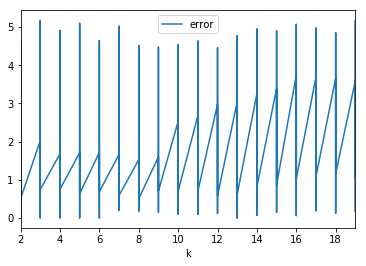

In [140]:
s_test.plot(x='k', y='error', kind='line')

In [141]:
s_test

inv_dist   k     pred_x  pred_x_weighted     pred_y  pred_y_weighted  \
0     0.425997   2   0.000000         0.000000   0.500000         0.415333   
1     0.673618   2   0.000000         0.000000   0.500000         0.732063   
2     0.447731   2   1.000000         1.066904  10.000000         9.933096   
3     0.645146   2   0.500000         0.321712  11.000000        11.000000   
4     0.357944   2   2.000000         2.000000  10.500000        10.424221   
5     0.530758   2   0.500000         0.379347  12.500000        12.620653   
6     0.720880   2   0.000000         0.000000   6.000000         5.443618   
7     0.539983   2   1.000000         0.926600   3.000000         3.000000   
8     0.461852   2   0.500000         0.475592   4.000000         4.000000   
9     0.434761   2   0.000000         0.000000   7.500000         7.396777   
10    0.315750   2   2.500000         2.375000   7.000000         7.000000   
11    0.415216   2   0.500000         0.450018   7.500000         7.649945   
12    0.350396   2   1.500000         1.504586   2.000000         2.009171   
13    0.474502   2   0.500000         0.502099   0.500000         0.502099   
14    0.485569   2   1.500000         1.462254  10.000000        10.075491   
15    0.520042   2   0.500000         0.521178  11.000000        11.000000   
16    0.382659   2   0.000000         0.000000  11.500000        11.572441   
17    0.373193   2   1.000000         1.000000  12.500000        12.382571   
18    0.426729   2   0.000000         0.000000   6.500000         6.935748   
19    0.467040   2   0.500000         0.597336   3.000000         3.000000   
20    0.497457   2   1.500000         1.476676   5.000000         4.953351   
21    0.486183   2   1.500000         1.468088   4.000000         4.063824   
22    0.548207   2   0.500000         0.687288   7.500000         6.938136   
23    0.492673   2   0.500000         0.611779   7.500000         7.388221   
24    0.414775   2   1.000000         1.000000   7.500000         7.534399   
25    0.456730   2   1.500000         1.411473   9.000000         9.000000   
26    0.311354   2  12.000000        11.897097   3.000000         3.000000   
27    0.350267   2   9.500000         9.636402   3.500000         3.636402   
28    0.447753   2  10.500000        10.557165   4.000000         3.885669   
29    0.467390   2  10.500000        10.286349   6.000000         6.000000   
...        ...  ..        ...              ...        ...              ...   
2958  2.347577  19  30.631579        30.696890   6.105263         6.250510   
2959  1.938960  19  30.631579        30.789855   5.473684         5.250957   
2960  2.218078  19  30.157895        30.621498   5.894737         5.658497   
2961  2.165256  19  31.105263        31.276450   5.684211         5.312311   
2962  1.959213  19  30.421053        30.759394   5.684211         5.620171   
2963  2.130283  19  30.210526        30.570930   6.000000         5.939391   
2964  2.236273  19  30.105263        30.420935   6.263158         6.505093   
2965  1.781863  19  28.157895        28.394036   4.842105         4.696579   
2966  1.877069  19  30.736842        30.907924   5.789474         5.718581   
2967  1.895347  19  29.947368        30.168196   6.789474         6.959875   
2968  1.825984  19  30.368421        30.741267   6.315789         6.501729   
2969  2.157780  19   5.210526         5.132289   5.631579         5.095543   
2970  1.981760  19   2.842105         2.813003   6.578947         6.724462   
2971  1.944399  19   2.578947         2.656939   6.684211         6.777141   
2972  1.951862  19   9.105263         9.129251   5.157895         5.019373   
2973  2.097213  19   6.684211         6.282197   6.894737         6.931385   
2974  2.205851  19   6.526316         6.376789   6.842105         6.874439   
2975  2.132119  19   7.684211         7.424804   5.421053         5.178662   
2976  2.032587  19   7.473684         7.157185   6.789474         6.846047   
2977  2.306383  19   6.94736

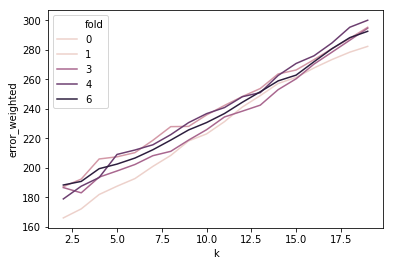

In [106]:
sns.lineplot(data=results, x='k', y='error_weighted', hue='fold')

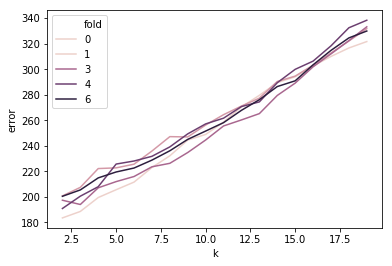

In [107]:
#pd.DataFrame(cv_results).plot(x='k', y='error', kind='line', hue='fold')
sns.lineplot(data=results, x='k', y='error', hue='fold')

In [ ]:
sns.lineplot(data=results, x='k', y='error', hue='fold')

### Online Predictions

Using the optimal values of k and m selected in cross validation, we will make predictions on the **online** testing set using the same methodology outlined above.

In [112]:
final_model_predictions = cross_validate(df, df_online, ks=range(1, 10), m=3)

1
2
3
4
5
6
7
8
9


[Text(0, 0.5, 'error'), Text(0.5, 1.0, 'Error vs k')]

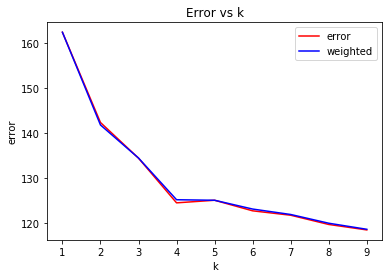

In [114]:
results = []
for key, predictions in final_model_predictions.groupby(['k']):
    scored = score(predictions)
    error = scored.error.sum()
    error_weighted = scored.error_weighted.sum()
    results.append({
        'k':key,
        'error':error,
        'error_weighted':error_weighted
    })

results = pd.DataFrame(results)
p = sns.lineplot(data=results, x='k', y='error', color='red', label='error')
sns.lineplot(data=results, x='k', y='error_weighted', color='blue', label='weighted')
p.set(title='Error vs k', ylabel='error')


### cd or c0?

It has been suggested that one of these two devices may be faulty. Let's see if our modeling improves if we leave one of the devices in and the other out. 

In [74]:
macs_no_c0 = ['00:0f:a3:39:dd:cd', 
            '00:14:bf:b1:97:8a',
            '00:14:bf:3b:c7:c6',    
            '00:14:bf:b1:97:90',  
            '00:14:bf:b1:97:8d',
            '00:14:bf:b1:97:81',
            '02:00:42:55:31:00']
macs_no_cd = ['00:0f:a3:39:e1:c0',     
            '00:14:bf:b1:97:8a',
            '00:14:bf:3b:c7:c6',    
            '00:14:bf:b1:97:90',  
            '00:14:bf:b1:97:8d',
            '00:14:bf:b1:97:81',
            '02:00:42:55:31:00']

error  error_weighted  fold  k
0  128.358204     1377.447457     1  2
1  125.021621     1378.087474     2  2
2  130.143772     1376.870179     3  2
3  127.203516     1375.336588     4  2
4  130.994790     1376.628612     5  2
5  128.488036     1375.039719     6  2
6  127.266399     1377.426086     7  2
7  129.481784     1376.226008     8  2
8  130.015980     1376.502636     9  2

In [43]:
sample?

In [ ]:
cross_val_results_new = []
#not checking angle balance here is a problem -  note in summary
for fold in range(1, 2): #5 folds
    all_indices = set(df.index)
    keep = int(round(len(all_indices)*0.8, 0))
    train_labels = set(sample(all_indices, keep))
    test_labels = all_indices.difference(train_labels)
    train_data = df.loc[train_labels]
    test_data = df.loc[test_labels]
    test_data = test_data.groupby(['mac', 'xy-loc'])['signal'].agg(['mean']).reset_index()
    test_data = pd.pivot_table(test_data, values='mean', columns='mac', index=['xy-loc'])
    test_data['dummy_angle'] = test_data.apply(lambda x: sample(angles, 1)[0], axis=1)
    cv = cross_validate(train_data, test_data, ks=range(2, 6), m=3)
    cv['fold'] = fold
    cross_val_results_new.append(cv)
    print(f'Fold: {fold} completed')
    
cross_val_results_new = pd.concat(cross_val_results_new)

2
3
4
5


In [ ]:
results = []
for k, predictions in cross_val_results_new.groupby(['fold','k']):
    scored = score(predictions)
    error = scored.error.sum()
    error_weighted = scored.error_weighted.sum()
    results.append({
        'k':k[1],
        'fold':k[0],
        'error':error,
        'error_weighted':error_weighted
    })

results = pd.DataFrame(results)
results = results[results.k <= 10]
p = sns.lineplot(data=results, x='k', y='error', color='red', label='error')
sns.lineplot(data=results, x='k', y='error_weighted', color='blue', label='weighted')
p.set(title=f'Error vs k', ylabel='error')